# Figures with TPZ data

in this notebook we will make some close-to-publication quality figures using the TPZ data and the pzblend codebase. 

In [1]:
import sys

I needed to add this path, where I have supporting packages for pzblend set up, like dask and daskml

In [2]:
sys.path.insert(0,'/global/homes/i/ihasan/python_stuff/lib/python3.7/site-packages/')

In [3]:
sys.path.insert(0,'/global/homes/i/ihasan/pz_blend/')

In [4]:
import pzblend

In [5]:
import numpy as np
import pandas as pd
import GCRCatalogs
from GCR import GCRQuery
from pzblend import PhotozBlend
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dustmaps
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
from dustmaps.config import config

In [6]:
# plotting parameters to make font big
plt.rc('axes', labelsize=25)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.rcParams['xtick.minor.visible'] = True

In [7]:
# paths to the TPZ data we created in sprint week
# point estimates
mlz = "/global/cfs/cdirs/lsst/groups/PZ/PZBLEND/SPRINTWEEK/output/results/Run2.2i_dr6_100k.11.mlz"
# pdfs
pdfs = "/global/cfs/cdirs/lsst/groups/PZ/PZBLEND/SPRINTWEEK/output/results/Run2.2i_dr6_100k.11.P.npy"
# data that contains magnitudes, magnitude errors, and colors
validation = "/global/cfs/cdirs/lsst/groups/PZ/PZBLEND/Run2.2i_dr6/Run2.2i_dr6_dered_test.txt"

mlz_np = np.genfromtxt(mlz)
# the last entry in the pdfs is the zs
pdfs_np = np.load(pdfs)
zs = pdfs_np[-1]
pdfs_np = pdfs_np[:-1]
valid_np = np.genfromtxt(validation)

# create the column names for the data we read in. For some reason I couldn't get pandas to just read 
# in the data, so I have to do this klugy work around where I use numpy to read in the raw data
# and then make the columns by hand to make pandas dataframes. pzblend expects these dataframes as input
bands = ['u','g','r','i','z','y']
errs = ['e{}'.format(i) for i in bands]
colors = ['u-g','g-r','r-i','i-z','z-y']
valid_names = bands + colors + errs + ['ra','dec','objId']

mlz_names = ["ztrue",'z_mode', "zmean","zConf0",'zConf1','err0','err1']
pdf_names = "photoz_pdf"

mlz_df = pd.DataFrame(mlz_np, columns=mlz_names)
valid_df = pd.DataFrame(valid_np, columns=valid_names)
valid_df['photoz_pdf'] = list(pdfs_np)

# mash these dataframes together to make the coadd data frame. this is an input for pzblend
coadd_df = pd.concat([valid_df, mlz_df], axis=1)
# pzblend also expects a specific column, 'mag_i_lsst'. Just make it an alias for the i band
coadd_df['mag_i_lsst'] = coadd_df['i']

# use GCR to get the truth catalog that overlaps with our TPZ data. pzblend expects this as input
truth_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
truth_data = truth_cat.get_quantities(['ra', 'dec', 'galaxy_id','halo_id', 'redshift','mag_i', 'mag_i_lsst',
                                       'mag_g', 'mag_r'],filters=['mag_i_lsst < 28.','dec < -38.5'])
truth_df = pd.DataFrame(truth_data)

In [8]:
pzb = PhotozBlend(truth_df, coadd_df, zs)
pzb.fof_match(verify=True, plot=False, load_cached=True) #save_cached=True

<module>:fof_match: FoF results are verified, everything looks good.


In [10]:
# to make zz plots we need point estimates and the true redshift information
# we can use the filtering stuff Erfan set up to grab this data. Get the 2-1 case truthpick bright
# this takes a while to run
i_truth_bright_21, redshift_bright_21 = pzb.filter('truth', 2, 1, where={'mag_i_lsst': 'min'}).get('mag_i_lsst','redshift')

INFO:root:get:translate_easy_string: Evaluating ['mag_i_lsst', 'redshift'] in the truth catalog after filtering has already been done
INFO:root:<module>:get: Columns accessible for the 2 evaluations: ['galaxy_id', 'redshift', 'mag_i_lsst', 'mag_g', 'dec', 'mag_i', 'ra', 'mag_r', 'halo_id', 'group_id']


✓ Done!


In [11]:
# get the 2-1 case truthpick faint.
# this takes a while to run
i_truth_faint_21, redshift_faint_21 = pzb.filter('truth', 2, 1, where={'mag_i_lsst': 'max'}).get('mag_i_lsst','redshift')
# get the observed coadd information for the 2-1 case
i_coadd_21, z_mode_21 = pzb.filter('coadd', 2, 1).get('i','z_mode')

INFO:root:get:translate_easy_string: Evaluating ['mag_i_lsst', 'redshift'] in the truth catalog after filtering has already been done
INFO:root:<module>:get: Columns accessible for the 2 evaluations: ['galaxy_id', 'redshift', 'mag_i_lsst', 'mag_g', 'dec', 'mag_i', 'ra', 'mag_r', 'halo_id', 'group_id']


✓ Done!


In [13]:
truth_df.columns

Index(['dec', 'ra', 'galaxy_id', 'mag_g', 'halo_id', 'mag_i_lsst', 'redshift',
       'mag_i', 'mag_r'],
      dtype='object')

In [1]:
coadd_df.columns

NameError: name 'coadd_df' is not defined

In [12]:
# truth information for the 1-1 case
i_truth_bright_11, redshift_bright_11 = pzb.filter('truth', 1, 1, where={'mag_i_lsst': 'min'}).get('mag_i_lsst','redshift')

INFO:root:get:translate_easy_string: Evaluating ['mag_i_lsst', 'redshift'] in the truth catalog after filtering has already been done
INFO:root:<module>:get: Columns accessible for the 2 evaluations: ['galaxy_id', 'redshift', 'mag_i_lsst', 'mag_g', 'dec', 'mag_i', 'ra', 'mag_r', 'halo_id', 'group_id']


✓ Done!


In [13]:
# get the observed coadd information for the 1-1 case
i_coadd_11, z_mode_11 = pzb.filter('coadd', 1, 1).get('i','z_mode')

In [14]:
# this creates dmag1, boolean mask to give you 2-1 galaxies that are 1 mag apart or less
dmag1 = i_truth_faint_21 - i_truth_bright_21 < 1

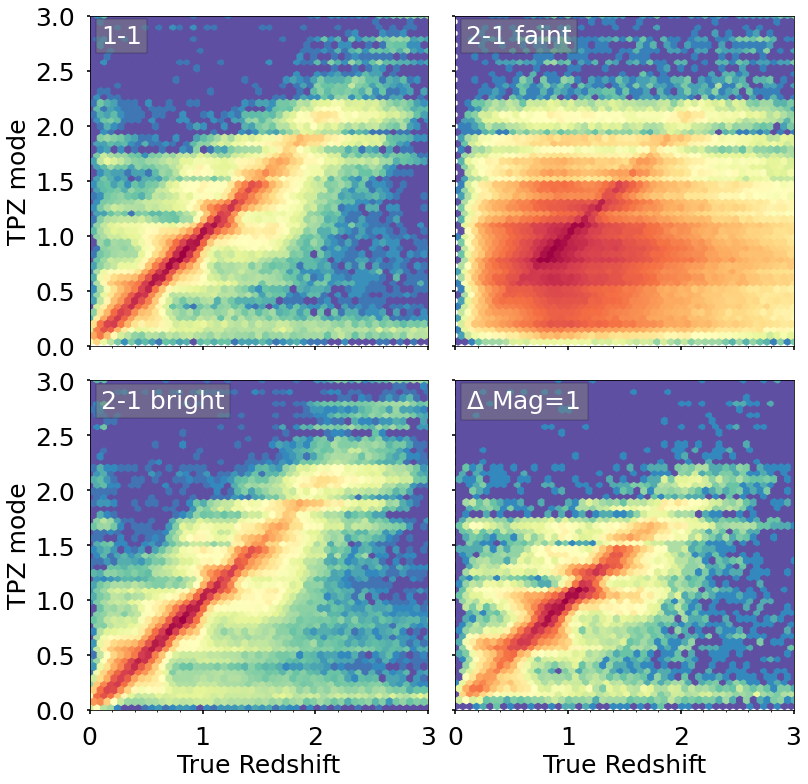

In [15]:
colorbar='horizontal' 
pad='1.3%'
cmap=plt.cm.Spectral_r
annotate=True

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11,11))
im00 = ax[0,0].hexbin(redshift_bright_21, z_mode_21, gridsize=50, bins='log', cmap=cmap)
im01 = ax[0,1].hexbin(redshift_faint_21, z_mode_21, gridsize=50, bins='log', cmap=cmap)
im10 = ax[1,0].hexbin(redshift_bright_11, z_mode_11, gridsize=50, bins='log',cmap=cmap)
im11 = ax[1,1].hexbin(redshift_bright_21[dmag1], z_mode_21[dmag1], gridsize=50, bins='log', cmap=cmap)
#im11 = ax[1,1].axis('off')

for a in ax.flatten():
    a.set_xlim([0,3])
    a.set_ylim([0,3])

ax[0,0].text(.1,2.75,"1-1", color='white', fontsize=25,bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5})
ax[0,1].text(.1,2.75,"2-1 faint", color='white', fontsize=25,bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5})
ax[1,1].text(.1,2.75,r"$\Delta$ Mag=1 ", color='white', fontsize=25,bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5})
ax[1,0].text(.1,2.75,"2-1 bright", color='white', fontsize=25,bbox={'facecolor': 'grey', 'alpha': 0.5, 'pad': 5})    

ax[1,0].set_xlabel('True Redshift')
ax[0,0].set_ylabel('TPZ mode')
ax[1,0].set_ylabel('TPZ mode')
ax[1,1].set_xlabel("True Redshift")
plt.tight_layout()
plt.savefig('output/tpz-zz.pdf', dpi=300, bbox_inches = "tight")

## Point Statistics

## 1-1 case

In [9]:
pzb.calc_point_statistics(num_truth=1, num_coadd=1, pz_type='z_mode')

INFO:root:calc_point_statistics:load_redshifts: New redshift dataframes have been created.


(0.031079737814029486, 0.0036136399932830093, 0.042936067498938746)

In [11]:
bin_edges_optimized = np.histogram_bin_edges(pzb.true_z, bins='auto')
count, bins = np.histogram(pzb.true_z, bins=bin_edges_optimized)
delta_bin = bins[1] - bins[0]
z = bins[:-1] + delta_bin
np.sum(np.power(z,3)*count*delta_bin)/(np.sum(count*delta_bin))

1.0838932129214305

In [10]:
pzb.KL_divergence()

INFO:root:KL_divergence:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:KL_divergence:calc_pits: New PIT values have been created.


0.036544877224977075

INFO:root:plot_pdf:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:plot_pdf:stack_photoz: New stacked photoz's have been created.
INFO:root:plot_pdf:kde_dask: Estimated the bandwidth of the kernel using the scott method to be 0.024.
INFO:root:<module>:plot_pdf: The plot is saved in '/global/u1/i/ihasan/pz_blend/notebooks/output/plots/pdf-1-1-tpz.pdf'


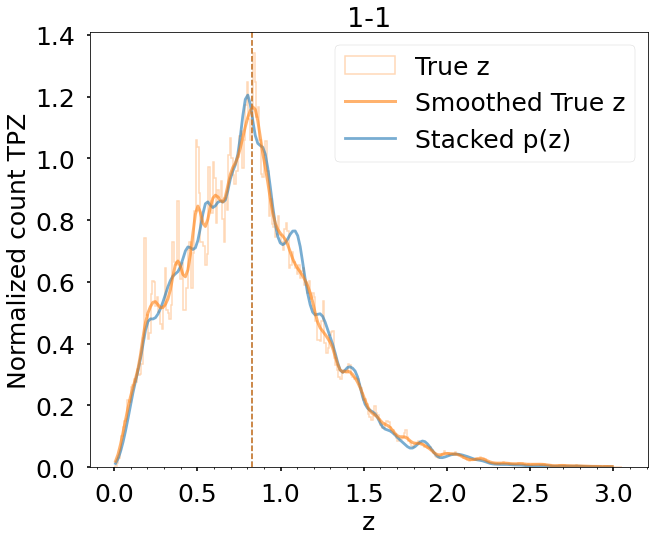

In [17]:
pzb.plot_pdf(num_truth=1, num_coadd=1, pz_type='z_mode', save_plot=True, save_name='pdf-1-1-tpz.pdf', show_legend=True, ylabel='Normalized count TPZ', title='1-1')

In [34]:
pzb.KS_PDF()

INFO:root:KS_PDF:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PDF:stack_photoz: The stacked photoz remained unchanged since no update was needed.


0.007379522234220781

INFO:root:plot_pit:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:plot_pit:calc_pits: New PIT values have been created.
INFO:root:<module>:plot_pit: The plot is saved in '/global/u1/i/ihasan/pz_blend/notebooks/output/plots/pit-1-1-tpz.pdf'


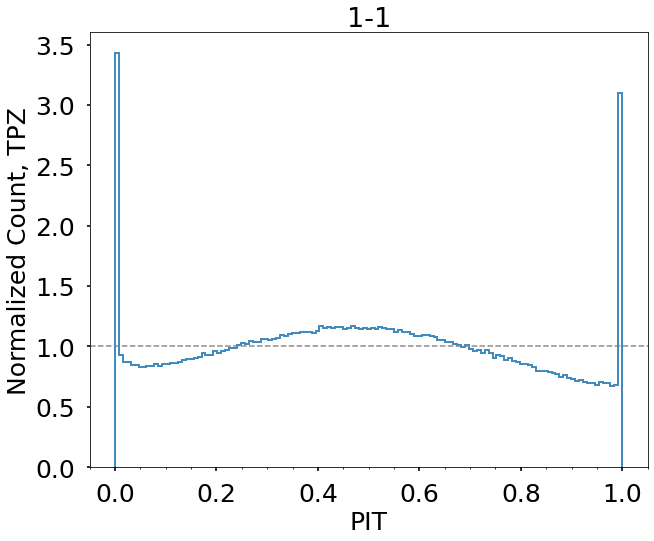

In [10]:
pzb.plot_pit(save_plot=True, save_name='pit-1-1-tpz.pdf', ylabel='Normalized Count, TPZ', title="1-1")

In [26]:
pzb.KS_PITS(num_truth=1, num_coadd=1, pz_type='z_mode')

INFO:root:KS_PITS:load_redshifts: New redshift dataframes have been created.


INFO:root:KS_PITS:calc_pits: New PIT values have been created.


KstestResult(statistic=0.03929801398360988, pvalue=0.0)

In [31]:
pzb.calc_cde_loss()

-0.15296412471773338

In [32]:
pzb.calc_3_moments()

{'first': 0.830262783136449,
 'second': 0.8577690079398238,
 'third': 1.0367018015028706}

## 2-1 Case, bright

the point statistics are         
* sig_iqr:
  the std deviation of the ez values
* bias: 
  the median of the ez values
* cat_outlier rate:
  The fraction of ez values greater than 0.15

In [12]:
pzb.calc_point_statistics(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='bright')

INFO:root:calc_point_statistics:load_redshifts: New redshift dataframes have been created.


(0.03680182499140753, 0.003285497939606967, 0.06866132509915618)

In [15]:
pzb.true_z.mean()

0.8718478554222935

In [14]:
bin_edges_optimized = np.histogram_bin_edges(pzb.true_z, bins='auto')
count, bins = np.histogram(pzb.true_z, bins=bin_edges_optimized)
delta_bin = bins[1] - bins[0]
z = bins[:-1] + delta_bin
np.sum(np.power(z,3)*count*delta_bin)/(np.sum(count*delta_bin))

1.2615444540335081

In [17]:
pzb.KL_divergence()

INFO:root:KL_divergence:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:KL_divergence:calc_pits: New PIT values have been created.


0.05514647727071424

INFO:root:plot_pdf:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:plot_pdf:stack_photoz: New stacked photoz's have been created.
INFO:root:plot_pdf:kde_dask: Estimated the bandwidth of the kernel using the scott method to be 0.031.
INFO:root:<module>:plot_pdf: The plot is saved in '/global/u1/i/ihasan/pz_blend/notebooks/output/plots/pdf-2-1-bright-tpz.pdf'


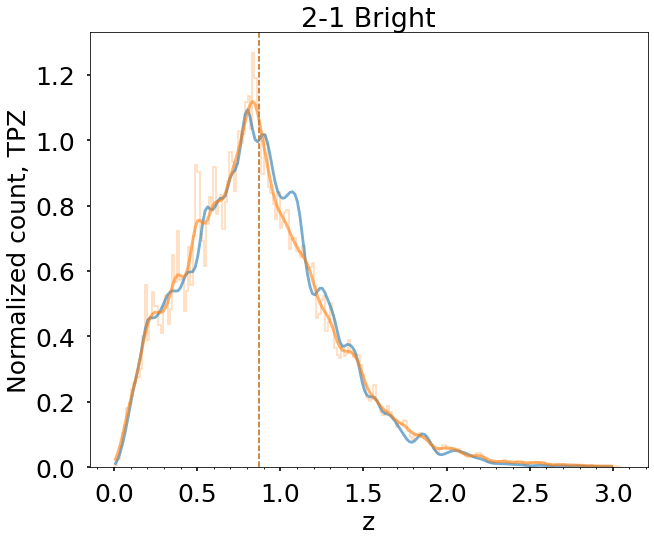

In [12]:
pzb.plot_pdf(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='bright', save_plot=True, save_name='pdf-2-1-bright-tpz.pdf', ylabel='Normalized count, TPZ', title='2-1 Bright')

In [39]:
pzb.KS_PDF()

INFO:root:KS_PDF:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PDF:stack_photoz: The stacked photoz remained unchanged since no update was needed.


0.013119286626754212

INFO:root:plot_pit:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:plot_pit:calc_pits: New PIT values have been created.
INFO:root:<module>:plot_pit: The plot is saved in '/global/u1/i/ihasan/pz_blend/notebooks/output/plots/pit-2-1-bright-tpz.pdf'


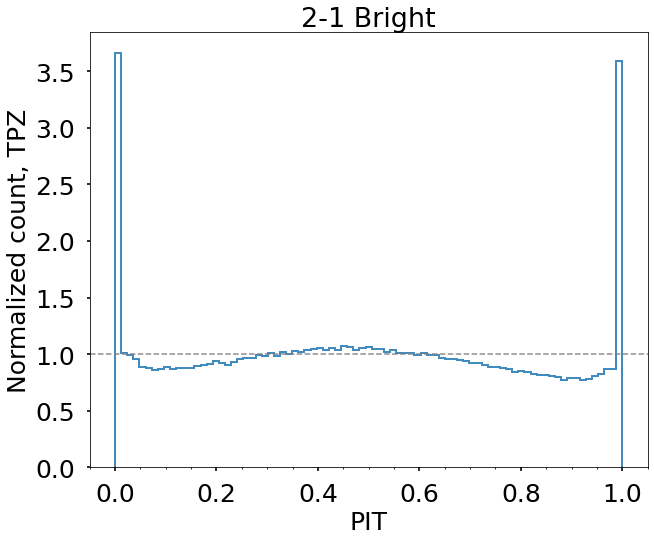

In [12]:
pzb.plot_pit(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='bright', save_plot=True, save_name='pit-2-1-bright-tpz.pdf', ylabel='Normalized count, TPZ', title='2-1 Bright')

In [43]:
pzb.KS_PITS()

INFO:root:KS_PITS:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PITS:calc_pits: The PIT values remained unchanged since no update was needed.


KstestResult(statistic=0.03230972860198516, pvalue=0.0)

In [44]:
pzb.calc_cde_loss()

-0.13772091224013666

In [45]:
pzb.calc_3_moments()

{'first': 0.8703338379403777,
 'second': 0.9372098463400297,
 'third': 1.1715868815885782}

## 2-1 faint

In [16]:
pzb.calc_point_statistics(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='faint')

INFO:root:calc_point_statistics:load_redshifts: New redshift dataframes have been created.


(0.26697646062533414, -0.1300559007919287, 0.624784163405826)

In [17]:
pzb.true_z.mean()

1.2537826257393216

In [19]:
pzb.KL_divergence()

INFO:root:KL_divergence:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:KL_divergence:calc_pits: New PIT values have been created.


2.0539218657166654

INFO:root:plot_pdf:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:plot_pdf:stack_photoz: New stacked photoz's have been created.
INFO:root:plot_pdf:kde_dask: Estimated the bandwidth of the kernel using the scott method to be 0.043.
INFO:root:<module>:plot_pdf: The plot is saved in '/global/u1/i/ihasan/pz_blend/notebooks/output/plots/pdf-2-1-faint-tpz.pdf'


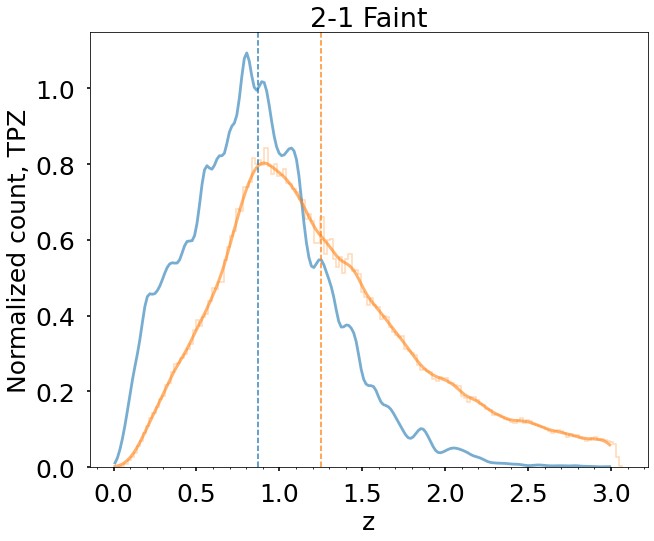

In [14]:
pzb.plot_pdf(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='faint', save_plot=True, save_name='pdf-2-1-faint-tpz.pdf', ylabel='Normalized count, TPZ', title='2-1 Faint')

I don't understand why this didn't work, I'll need to look more closely at the code

In [17]:
pzb.KS_PDF()

INFO:root:KS_PDF:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PDF:stack_photoz: The stacked photoz remained unchanged since no update was needed.


0.2707570541831838

INFO:root:plot_pit:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:plot_pit:calc_pits: New PIT values have been created.
INFO:root:<module>:plot_pit: The plot is saved in '/global/u1/i/ihasan/pz_blend/notebooks/output/plots/pit-2-1-faint-tpz.pdf'


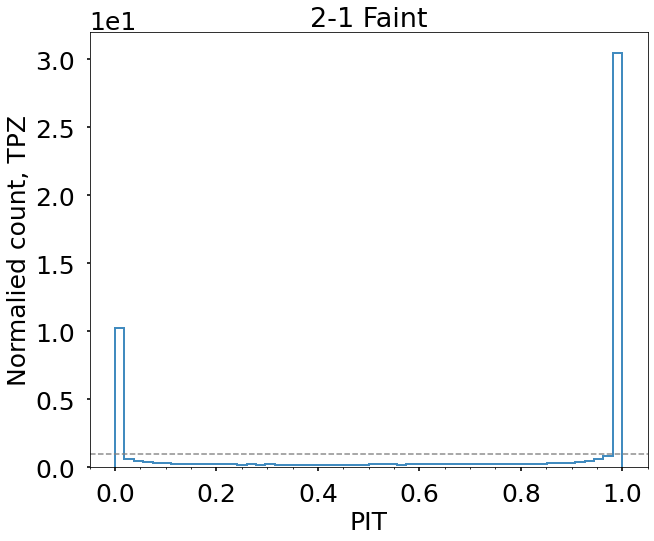

In [15]:
pzb.plot_pit(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='faint', save_plot=True, save_name='pit-2-1-faint-tpz.pdf', ylabel='Normalied count, TPZ', title='2-1 Faint')

In [49]:
pzb.KS_PITS()

INFO:root:KS_PITS:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PITS:calc_pits: The PIT values remained unchanged since no update was needed.


KstestResult(statistic=0.5460233993426284, pvalue=0.0)

In [50]:
pzb.calc_cde_loss()

-0.025756326319798798

In [51]:
pzb.calc_3_moments()

{'first': 0.8703338379403777,
 'second': 0.9372098463400297,
 'third': 1.1715868815885782}